In [2]:
import torch
from torch import log, exp
from kumaraswamy import KumaraswamyStable, KumaraswamyStableLogPDF, kumaraswamy_stable_log_pdf, kumaraswamy_stable_cdf

import matplotlib.pyplot as plt

import numpy as np
import math

## Distance between KS and closest bernoulli

Let $X \sim \text{KS}(a, b)$ be Kumaraswamy random variable.

The closest Bernoulli under many metrics (p=1, 2, etc...to prove)) bernoulli is the one with probability of success $p = P(X > 0.5)$.

There are many ways to define the distance between these two distributions. One such intutive way which I've come up with is $\mathbb{E}_{x \sim \text{KS}(a, b)}\big[\min\{{x, 1-x\}}\big]$. A simple interpretation of this is simply the minimum average cost to move all probability mass to closest endpoint $\{0, 1\}$. There may be a closed form solution to this for the KS. But because sampling the KS is so easy, we can simply sample and estimate this distance.

I believe this should correspond to some Wassertein metric. See Wikipedia for more details, particularly the section on 'One-dimensional distributions': https://en.wikipedia.org/wiki/Wasserstein_metric

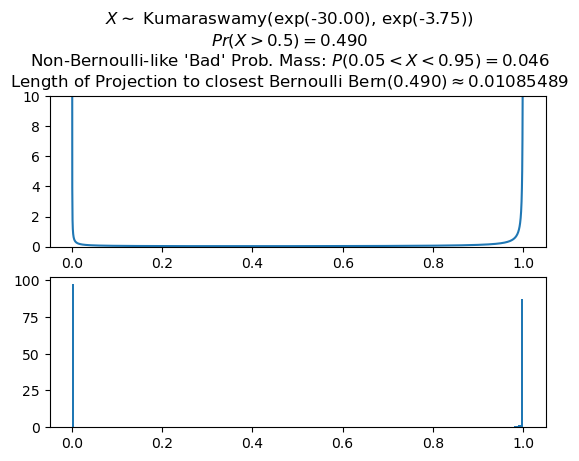

In [6]:
log_a = torch.tensor(-50)
log_b = torch.tensor(-4.28500000)

log_a = torch.tensor(-30)
log_b = torch.tensor(-3.75)
x = torch.linspace(1e-23, 1 - 1e-23, 5000)

ks_less_than_half = kumaraswamy_stable_cdf(torch.tensor(.5), log_a, log_b)
ks_greater_than_half = 1 - ks_less_than_half
#print(f"P(KS < .5) = {ks_less_than_half:.3f}, P(KS > .5) = {ks_greater_than_half:.3f}")

bad_prob_mass =  kumaraswamy_stable_cdf(torch.tensor(.95), log_a, log_b) - kumaraswamy_stable_cdf(torch.tensor(.05), log_a, log_b)
#print(f"Prob mass in [0.05, 0.95] = {bad_prob_mass:.3f}")

# approximate this value by sampling
n_samples = 100000
torch.manual_seed(0)
samples = KumaraswamyStable(log_a, log_b).sample(torch.Size([n_samples]))
min_samples = torch.min(samples, 1 - samples)
approx_wasserstein = min_samples.mean()
#print(f"Dist of KS({log_a}, {log_b}) to Bernoulli(KS > 0.5) = {approx_wasserstein:.8f} (approximated by sampling)")

# make subplots: pdf and histogram from samples
fig, axs = plt.subplots(2)
pdf = exp(kumaraswamy_stable_log_pdf(x, log_a, log_b))
axs[0].plot(x, pdf)
axs[0].set_ylim([0, 10])
axs[1].hist(samples.numpy(), bins=200, density=True)
title_str = r'$X \sim$ Kumaraswamy(' + f'exp({log_a:.2f}), exp({log_b:.2f}))'
title_str += "\n" + r'$Pr(X > 0.5) = $' + f'{ks_greater_than_half:.3f}'
title_str += "\nNon-Bernoulli-like 'Bad' Prob. Mass: " + r'$P(0.05 < X < 0.95) = $' + f'{bad_prob_mass:.3f}\n'
title_str += r'Length of Projection to closest Bernoulli Bern(' + f'{ks_greater_than_half:.3f})' +  r'$\approx$' + f'{approx_wasserstein:.8f}'
# add space beneath title before plots. Manually shift title up.
plt.subplots_adjust(top=0.8)

_ = plt.suptitle(title_str)